# A full SED-Fitting example

This tutorial goes through the things that need to be done to fit the observed spectral energy distributions (SEDs) of galaxies. This is different from SED fitting codes that use a sampler while fitting to create their posteriors, in the sense that we pre-sample the prior volume prior to fitting, trading space for time complexity. This results in a moderately lengthy initialization period where the method generates an atlas of parameters drawn from the priors and SEDs corresponding to these parameters with a user-specified filter-set, which can then be used to fit any number of SEDs in an extremely short amount of time. (Further iterations of the code are also planned to include variants with live samplers for edge-cases and objects with pathological likelihood surfaces.)

The atlas essentially provides a coarse mapping from the galaxy's stellar population parameters (stellar mass, SFR, star formation history, dust attenuation, metallicity, and redshift) to their corresponding SEDs.   

Instantiate the module, making sure you have all the prerequisite packages (especially python-fsps and george) installed. Don't worry if the initial import takes a few minutes, because it’s initializing its FSPS backend.

If you need to change any of the FSPS parameters, do so using `db.mocksp.params['key'] = value`, consulting the [python-fsps](http://dfm.io/python-fsps/current/stellarpop_api/#api-reference) API for reference. 

In [1]:
import numpy as np
import dense_basis as db

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.
Initialized stellar population with FSPS.


# Prerequisites to fitting: 

If you’re fitting photometry, put your photometric filter transmission curves in a folder somewhere and make a list of filter curves with the paths to each filter. You’ll need to pass `filter_list` and `filt_dir` as arguments to the code to generate SEDs corresponding to a given parameter set. 

The `db.plot_filterset()` function can be used to visualize the set of filter curves used to make SEDs. Let’s load a filter list corresponding to the CANDELS GOODS-South photometric catalog for now:

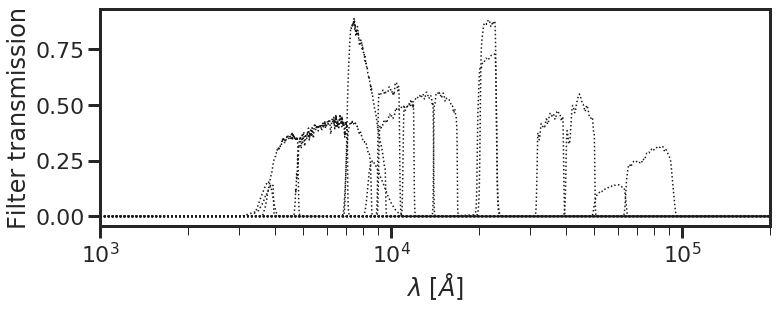

In [2]:
filter_list = 'filter_list_goodss.dat'
filt_dir = 'internal' # path to directory containing filter list
db.plot_filterset(filter_list = filter_list, filt_dir = filt_dir)

### 1. Instantiate a Priors() object

The next step is to generate a template atlas that you will use for fitting. The advantage of doing this is that we trade time-complexity for space, which is usually much more abundant, and it only needs to be done once to fit a large dataset. Before doing this, however, we need a set of priors that we can draw from to generate this atlas. This is done using the `db.Priors()` class:

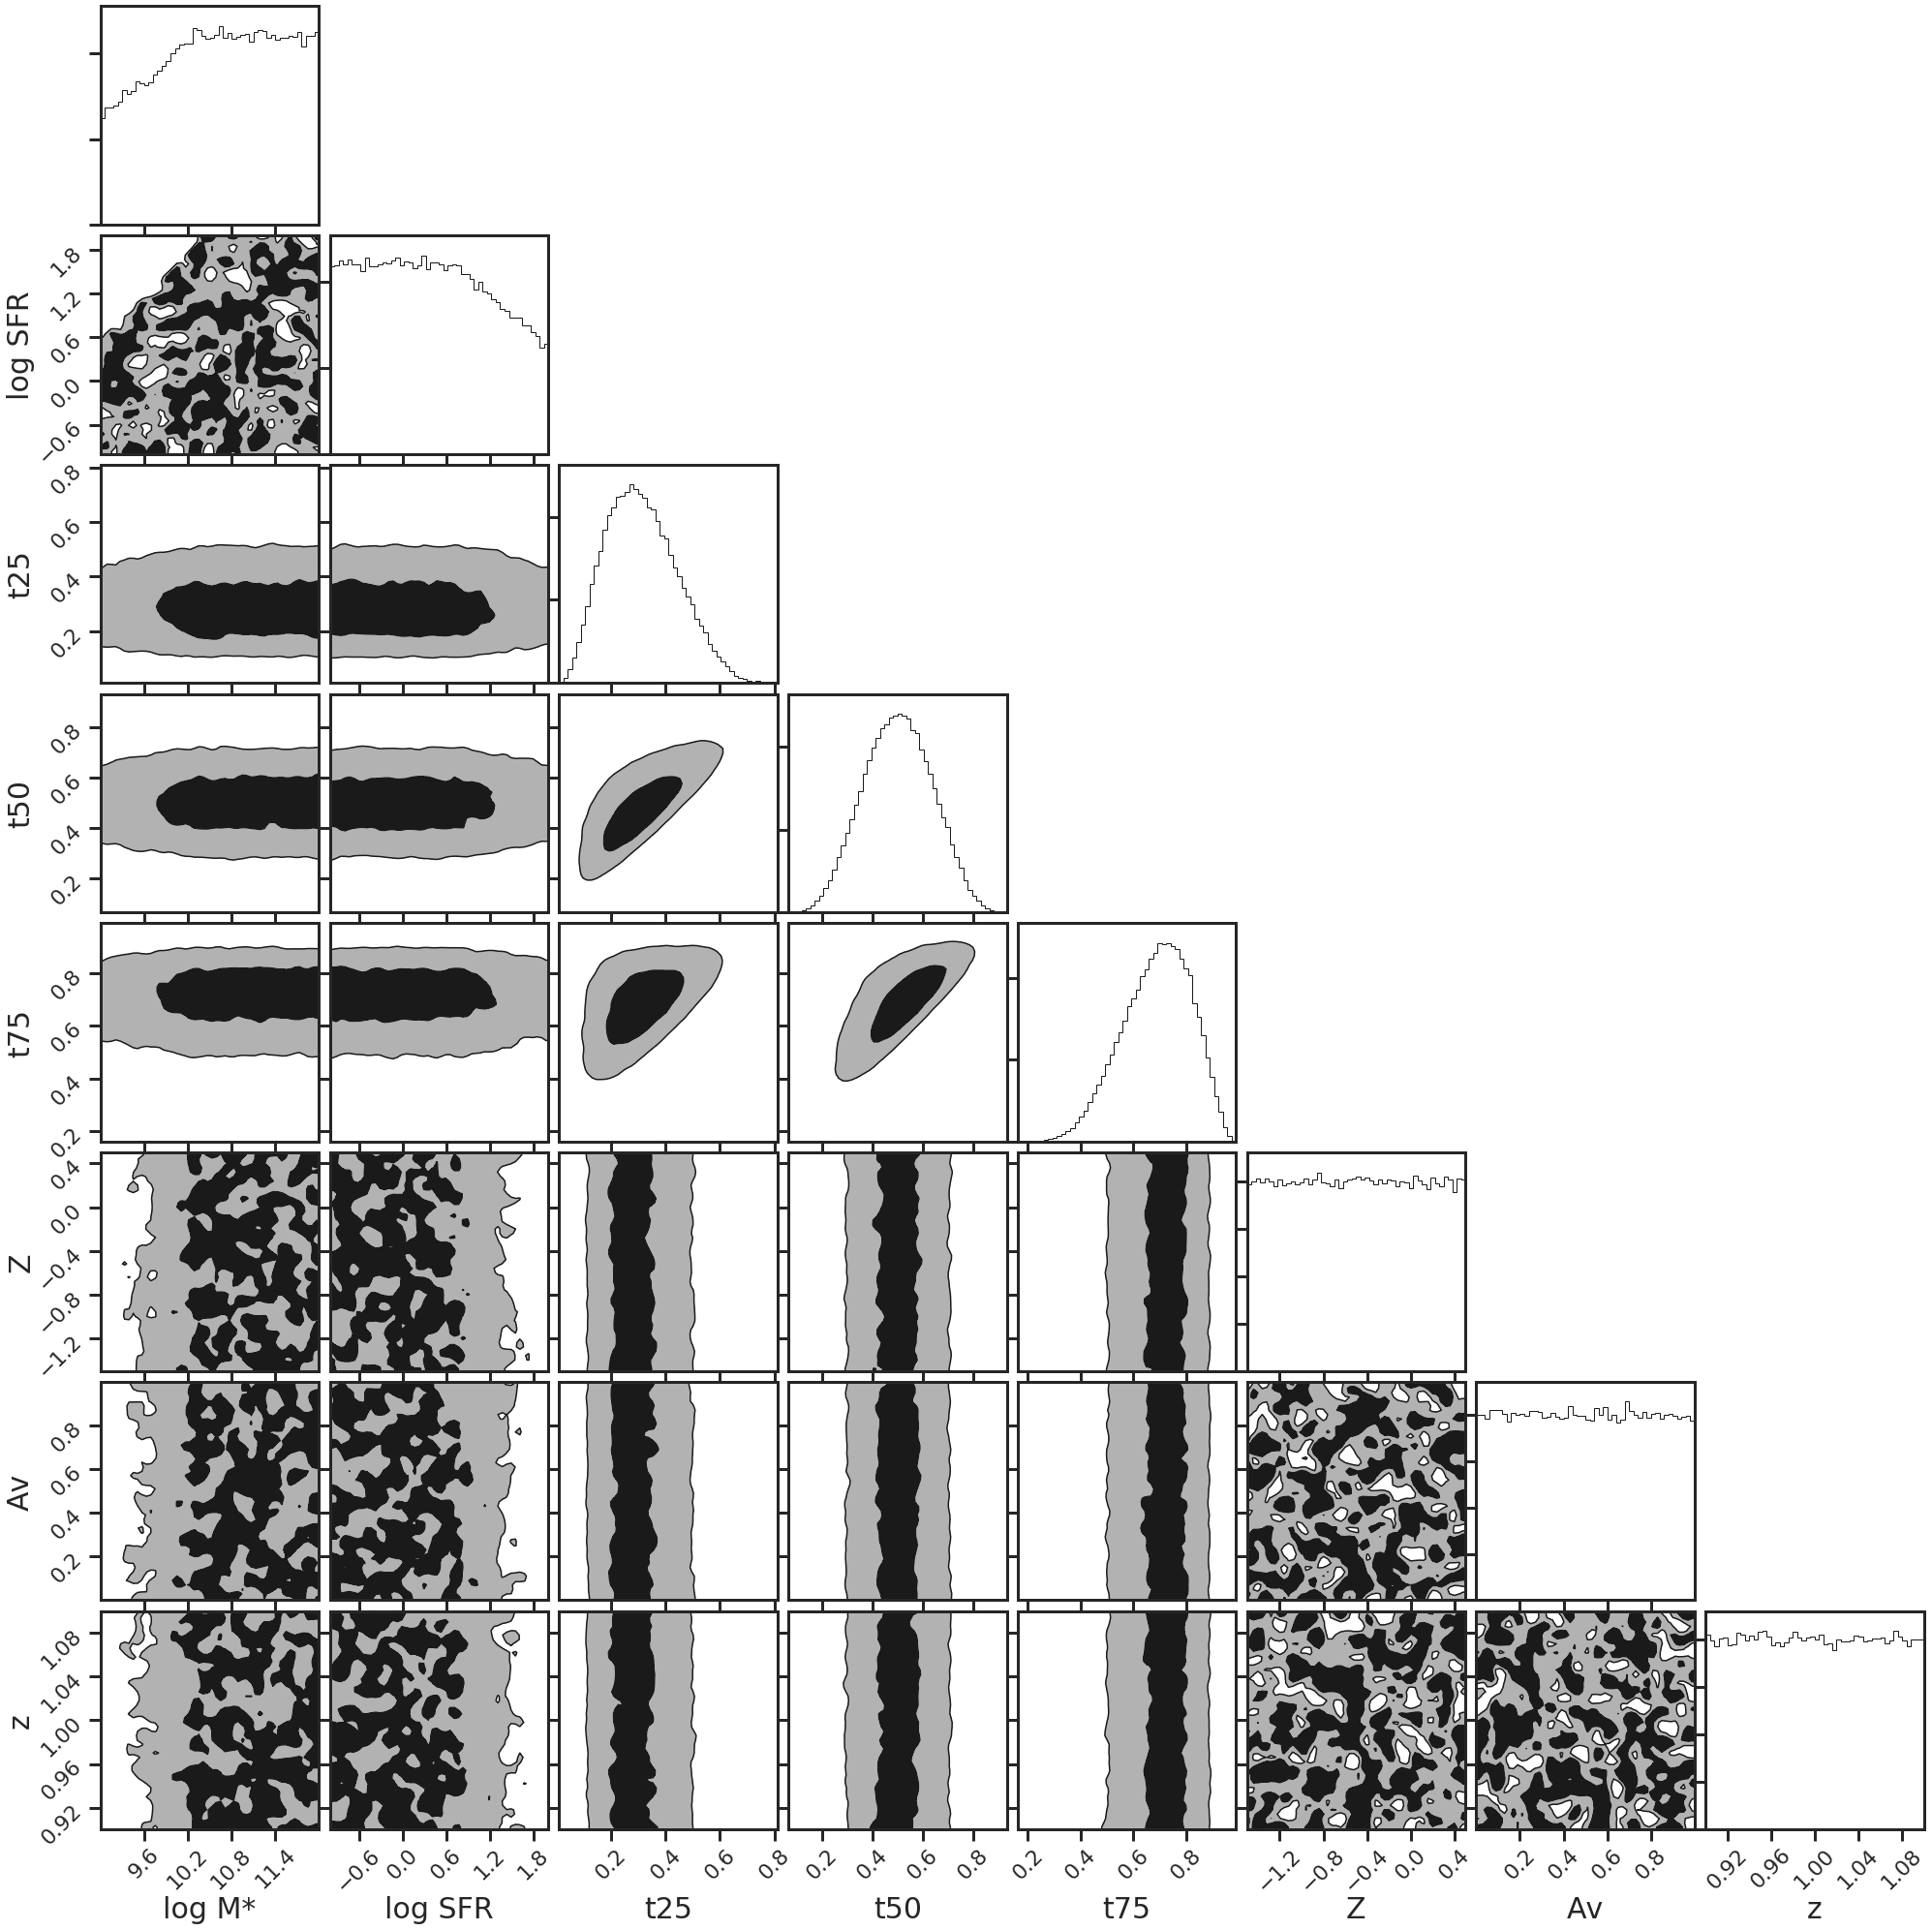

In [4]:
priors = db.Priors()
priors.tx_alpha = 3.0
priors.plot_prior_distributions()

### 2. Generate an atlas of parameters drawn from the prior and their corresponding SEDs.

Now we can use the priors object to generate the atlas. The important arguments here are the size of the atlas (`N_pregrid`), which samples from the overall multidimensional prior distributions, and the number of SFH parameters (`priors.Nparam`). The generated atlas is then stored in a local `/pregrids` folder with the user-specified fname within the current working directory. Please specify a different path using the `path` argument if you would like it to be stored in a different place. The first few SEDs take time to compute because every time FSPS encounters a new metallicity value it needs to load a grid into memory. This happens only once, and when it is done, the atlas generation process speeds up considerably.

In [4]:
fname = 'test_atlas'
N_pregrid = 1000
priors.Nparam = 3
db.generate_atlas(N_pregrid = N_pregrid, 
                  priors = priors, 
                  fname = fname, store=True, 
                  filter_list = filter_list, filt_dir = filt_dir)

100%|██████████| 1000/1000 [04:14<00:00,  3.93it/s]

Created directory and saved atlas at : pregrids/test_atlas_1000_Nparam_3.mat


### 3. Generate a mock SED to be fit.

To illustrate the SED fitting procedure, let’s generate a mock star formation history (SFH) to recover. This can be done by sampling our priors for an SFH-tuple and then converting it to a SFR-vs-time curve using the `db.tuple_to_sfh()` command. We can then generate its corresponding spectrum, and multiply the spectrum with our prespecified filter-set to get the corresponding SED. 

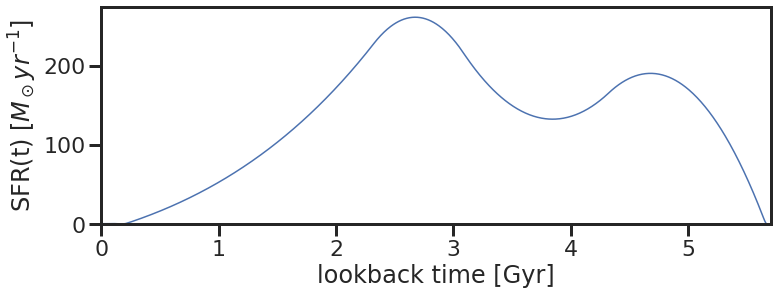

In [5]:
# sample from the prior space to get parameters 
rand_sfh_tuple, rand_Z, rand_Av, rand_z = priors.sample_all_params_safesSFR(random_seed = 24)

# generate an SFH corresponding to the SFH-tuple and see how it looks: 
rand_sfh, rand_time = db.tuple_to_sfh(rand_sfh_tuple, zval = rand_z) 
fig = db.plot_sfh(rand_time, rand_sfh, lookback=True) 
sfh_truths = [rand_time, rand_sfh]

# generate a corresponding spectrum and multiply by filter curves to get the SED: 
_, sfr_true, mstar_true = db.make_spec(rand_sfh_tuple, rand_Z, rand_Av, rand_z, return_ms = True)
rand_spec, rand_lam = db.make_spec(rand_sfh_tuple, rand_Z, rand_Av, rand_z, return_lam = True)
obs_sed = db.calc_fnu_sed(rand_spec, rand_z, rand_lam, fkit_name = filter_list, filt_dir = filt_dir) 
obs_err = obs_sed * 0.1 # S/N of 10
sed_truths = (mstar_true, sfr_true, rand_sfh_tuple[3:], rand_Z, rand_Av, rand_z)
sed_truths = np.hstack(sed_truths)

# SED fitting with the dense_basis package:

### 4. Load the previously generated atlas:

Step 2 is extremely beneficial in fitting large datasets, since the atlas needs to be generated only once and can be used for fitting as many SEDs as needed using the brute-force Bayesian approach. Having generated this dataset, now an arbitrary SED (`obs_sed`, and its errors `obs_err`) can be fit using the previously generated atlas. If you are interested in seeing how the fits change with a much more finely sampled atlas, try using the precomputed atlas with `N_pregrid = 300000` (I can not include bigger files due to Github's size limitations, but will try to do so on PyPI at a later date).

In [6]:
# if you want to see how the fits look with a bigger atlas, try this precomputed one:

fname = 'test_atlas'
N_pregrid = 300000
priors.Nparam = 3
path = 'internal'

# if instead you would like to use the atlas you just generated, comment the above and instead use:

# fname = 'test_atlas'
# N_pregrid = 1000
# priors.Nparam = 3
# path = 'pregrids/'

In [7]:
# load the atlas 
#pg_sfhs, pg_Z, pg_Av, pg_z, pg_seds, norm_method = db.load_atlas(fname, N_pregrid, priors.Nparam) 
pg_sfhs, pg_Z, pg_Av, pg_z, pg_seds, norm_method = db.load_atlas(fname, N_pregrid = N_pregrid, N_param = priors.Nparam, path = path) 
pg_theta = [pg_sfhs, pg_Z, pg_Av, pg_z, pg_seds]

# pass the atlas and the observed SED into the fitter, 
# fit params returns the median and 1-sigma values for the parameters being fit 
fit_params = db.fit_sed_pregrid(obs_sed, obs_err, pg_theta, norm_method=norm_method)

### 5. Fit the SED and visualize the parameter posteriors:

If we are interested in the full posteriors of the fit, this can be visualized by making the fitter return the chi2 array and then computing the full posteriors as prior*likelihood. Let’s see how it compares to the truth:

In [8]:
%timeit db.fit_sed_pregrid(obs_sed, obs_err, pg_theta, return_val = 'chi2', norm_method=norm_method)

66.2 ms ± 364 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
60/(66e-3)

909.090909090909

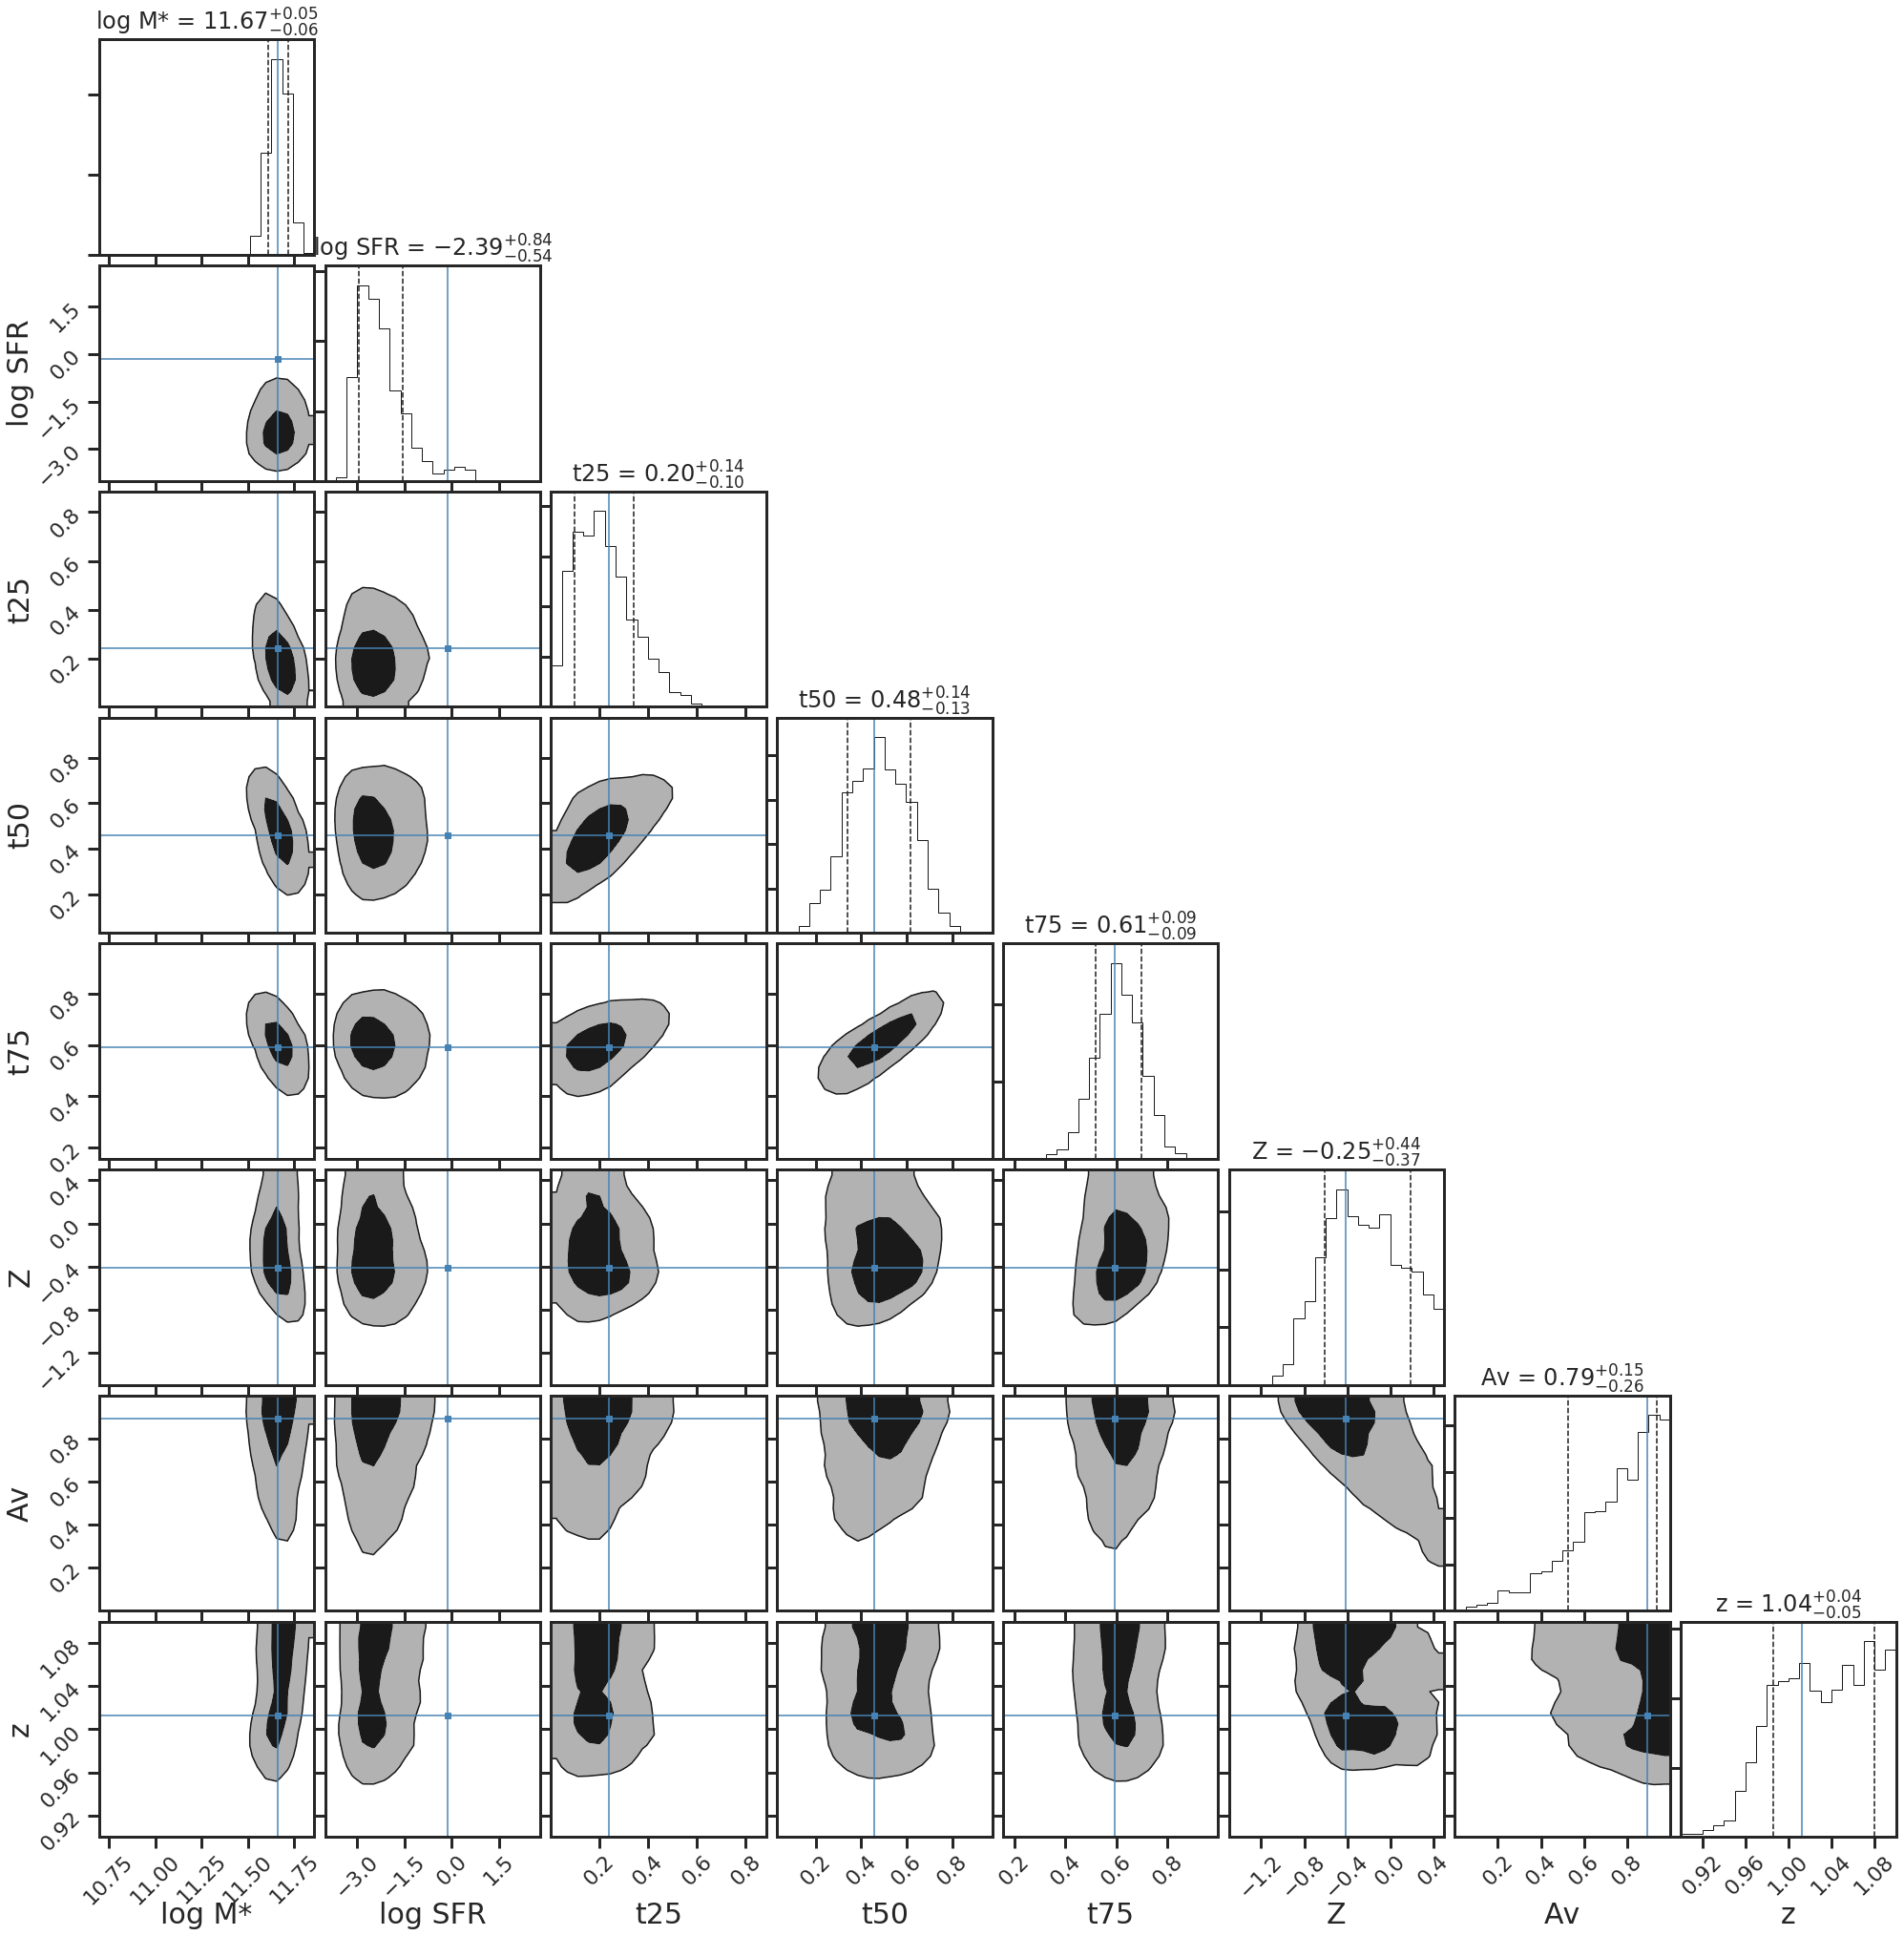

In [8]:
chi2_array = db.fit_sed_pregrid(obs_sed, obs_err,
pg_theta, return_val = 'chi2', norm_method=norm_method)

# plot parameter posteriors: 
db.plot_posteriors(chi2_array, obs_sed, pg_theta, truths = sed_truths)

### 6. Visualize the SFH posterior:

Finally, we can also plot the posterior SFH and see how it compares to the true SFH:

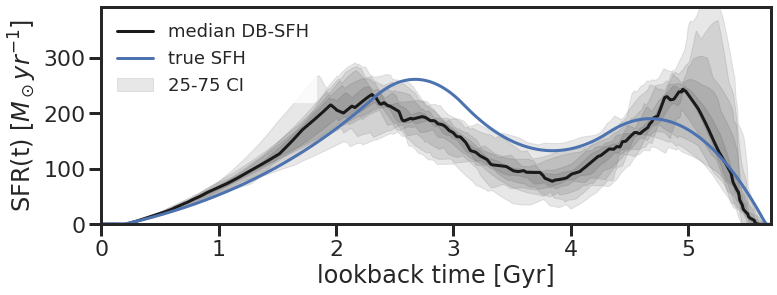

In [9]:
db.plot_SFH_posterior(chi2_array, obs_sed, pg_theta, 
                         truths = sfh_truths, sfh_threshold = 0.9)